In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
import sys
import os
sys.path.append(f'/home/{os.environ.get("USER")}/PythonLibrary')
import lgbextension as ex
import utils

In [41]:
train = utils.load_train()
test = utils.load_test()
prev = utils.read_pickles('../data/previous_application')

100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


In [42]:
# subset
#prev =prev[prev.NAME_CONTRACT_STATUS=='Approved'].drop('NAME_CONTRACT_STATUS', axis=1)

#prev = prev.sort_values(['SK_ID_CURR', 'DAYS_DECISION'], ascending=[True, False]).drop_duplicates('SK_ID_CURR', keep='first')


In [43]:
# colsample

col = [c for c in prev.columns if c.startswith('app_')]
prev.drop(col, axis=1, inplace=True)


In [44]:
col_cat = [c for c in prev.columns if prev[c].dtype=='O']

In [45]:
prev = pd.get_dummies(prev, columns=col_cat, drop_first=True)

In [46]:
tmp = pd.merge(prev, train[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')

In [47]:
prev_tr = tmp[~tmp.TARGET.isnull()].reset_index(drop=True)
prev_te = tmp[tmp.TARGET.isnull()].reset_index(drop=True)

In [48]:
tmp  = prev_tr[['SK_ID_CURR']].set_index('SK_ID_CURR')
tmp['y'] = prev_tr.TARGET.values
tmp['cnt'] = prev_tr['SK_ID_CURR'].value_counts()
tmp['w'] = 1 / tmp.cnt.values

In [49]:
X_tr = prev_tr.drop(['SK_ID_PREV', 'SK_ID_CURR', 'TARGET'], axis=1).reset_index(drop=True)
tmp.reset_index(inplace=True)

In [50]:
X_tr.shape

(1413701, 439)

In [51]:
tmp.shape

(1413701, 4)

In [52]:
tmp.tail()

,SK_ID_CURR,y,cnt,w
1413696,443544,0.0,22,0.045455
1413697,209732,0.0,6,0.166667
1413698,249544,0.0,3,0.333333
1413699,400317,0.0,9,0.111111
1413700,261212,0.0,9,0.111111


# CV

In [53]:
SEED = 71

param = {
         'objective': 'binary',
         'metric': 'auc',
         'learning_rate': 0.2,
         'max_depth': 6,
         'num_leaves': 63,
         'max_bin': 255,
         
         'min_child_weight': 10,
         'min_data_in_leaf': 150,
         'reg_lambda': 0.5,  # L2 regularization term on weights.
         'reg_alpha': 0.5,  # L1 regularization term on weights.
         
         'colsample_bytree': 0.9,
         'subsample': 0.9,
#         'nthread': 32,
         'nthread': 64,
         'bagging_freq': 1,
         'verbose':-1,
         'seed': SEED
         }


In [54]:
fold = 5
group_kfold = GroupKFold(n_splits=fold)
tmp['g'] = tmp.SK_ID_CURR % fold

In [55]:
dtrain = lgb.Dataset(X_tr, tmp.y)

In [56]:
ret = lgb.cv(param, dtrain, 9999, folds=group_kfold.split(X_tr, tmp.y, tmp.g), 
             stratified=False,
             early_stopping_rounds=100, verbose_eval=50,
             seed=SEED)


[50]	cv_agg's auc: 0.652086 + 0.00257234
[100]	cv_agg's auc: 0.653304 + 0.0025141
[150]	cv_agg's auc: 0.653134 + 0.00262983
[200]	cv_agg's auc: 0.652429 + 0.00272999


In [57]:
ret['auc-mean'][-1]

0.653550052295366

In [34]:
dtrain = lgb.Dataset(X_tr, tmp.y, weight=tmp.w)

ret = lgb.cv(param, dtrain, 9999, folds=group_kfold.split(X_tr, tmp.y, tmp.g), 
             stratified=False,
             early_stopping_rounds=100, verbose_eval=50,
             seed=SEED)

[50]	cv_agg's auc: 0.683551 + 0.00116634
[100]	cv_agg's auc: 0.68464 + 0.00125563
[150]	cv_agg's auc: 0.683401 + 0.000969399


In [58]:
model = lgb.train(param, dtrain, 100)

In [59]:
imp = ex.getImp(model)

In [63]:
imp.head()

,feature,split,gain
0,AMT_GOODS_PRICE-d-total_debt,90,15238.959805
1,AMT_ANNUITY-m-app_AMT_GOODS_PRICE,195,11344.598140
2,DAYS_LAST_DUE_1ST_VERSION-m-app_DAYS_BIRTH,67,10518.170499
3,AMT_ANNUITY-m-app_AMT_CREDIT,198,7845.242754
4,DAYS_DECISION,121,5987.397496


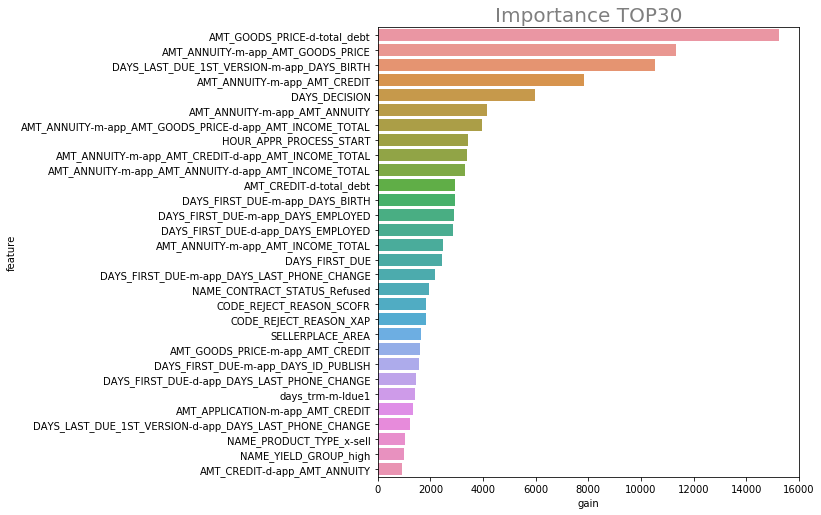

In [61]:
ex.pltImp(imp); plt.show()

In [62]:
def feature_vs_y(feature, y, feature_name=None, kind='kde', bw_method=None, bins=100):
    
    if feature_name is None:
        feature_name = feature.name
    
    df = y.to_frame('y')
    df[feature_name] = feature
    y0 = df[df.y==0]
    y1 = df[df.y==1]
    y0[feature_name].name = 'Actual:0'
    y1[feature_name].name = 'Actual:1'
    if kind=='kde':
        y0[feature_name].plot(kind='kde', legend=True, bw_method=bw_method)
        y1[feature_name].plot(kind='kde', legend=True, bw_method=bw_method)
    elif kind=='hist':
        y0[feature_name].plot(kind='hist',legend=True, bins=bins)
        y1[feature_name].plot(kind='hist',legend=True, bins=bins)
        
    plt.xlabel(f'{feature_name}')
    plt.title(f'{feature_name} Distribution', fontsize=13, alpha=0.5)
    plt.show()

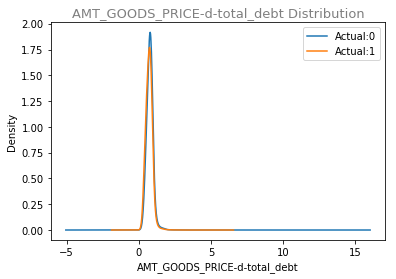

In [67]:
feature_vs_y(X_tr['AMT_GOODS_PRICE-d-total_debt'], tmp.y, bw_method=0.5)

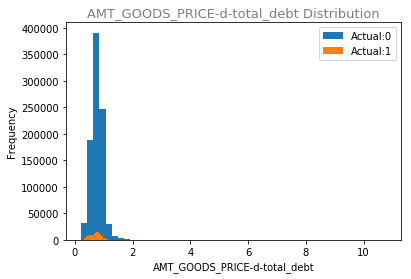

In [66]:
feature_vs_y(X_tr['AMT_GOODS_PRICE-d-total_debt'], tmp.y, kind='hist', bins=50)

# predict

In [68]:
X_tr.shape

(1413701, 439)

In [70]:
X_te = prev_te.drop(['SK_ID_PREV', 'SK_ID_CURR', 'TARGET'], axis=1).reset_index(drop=True)

In [71]:
X_te.shape

(256513, 439)

In [76]:
tmp['y_pred'] = 0

In [77]:
sub = prev_te[['SK_ID_PREV', 'SK_ID_CURR']]
sub['y_pred'] = 0

In [78]:
for train_index, test_index in group_kfold.split(X_tr, tmp.y, tmp.g):
    dtrain = lgb.Dataset(X_tr.iloc[train_index], tmp.iloc[train_index].y)
    dvalid = lgb.Dataset(X_tr.iloc[test_index], tmp.iloc[test_index].y)
    
    model = lgb.train(params=param, train_set=dtrain, num_boost_round=9999, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  early_stopping_rounds=100, 
                  #evals_result=evals_result, 
                  verbose_eval=50
                  )
    
    tmp.iloc[test_index, -1] = model.predict(X_tr.iloc[test_index])
    sub['y_pred'] += model.predict(X_te)

Training until validation scores don't improve for 100 rounds.
[50]	train's auc: 0.688205	valid's auc: 0.655653
[100]	train's auc: 0.705659	valid's auc: 0.656727
[150]	train's auc: 0.717896	valid's auc: 0.656251
[200]	train's auc: 0.730468	valid's auc: 0.655952
Early stopping, best iteration is:
[106]	train's auc: 0.707368	valid's auc: 0.656787
Training until validation scores don't improve for 100 rounds.
[50]	train's auc: 0.688276	valid's auc: 0.647237
[100]	train's auc: 0.705566	valid's auc: 0.648866
[150]	train's auc: 0.718293	valid's auc: 0.648071
Early stopping, best iteration is:
[93]	train's auc: 0.703649	valid's auc: 0.648921
Training until validation scores don't improve for 100 rounds.
[50]	train's auc: 0.685824	valid's auc: 0.652476
[100]	train's auc: 0.707254	valid's auc: 0.653873
[150]	train's auc: 0.720785	valid's auc: 0.653365
Early stopping, best iteration is:
[92]	train's auc: 0.703899	valid's auc: 0.654141
Training until validation scores don't improve for 100 rounds

In [80]:
sub.y_pred.describe()

count    256513.000000
mean          0.434545
std           0.225604
min           0.021394
25%           0.277965
50%           0.420130
75%           0.528173
max           2.666075
Name: y_pred, dtype: float64

In [81]:
sub.y_pred /= 5

In [83]:
sub.head()

,SK_ID_PREV,SK_ID_CURR,y_pred
0,1397919,321676,0.124594
1,2273188,270658,0.083100
2,1285768,142748,0.080824
3,2536650,338725,0.070441
4,2191093,182450,0.064916


In [84]:
tmp.head()

,SK_ID_CURR,y,cnt,w,g,y_pred
0,271877,0.0,3,0.333333,2,0.059995
1,108129,0.0,6,0.166667,4,0.038191
2,122040,0.0,4,0.250000,0,0.122890
3,176158,0.0,23,0.043478,3,0.048063
4,202054,0.0,25,0.040000,4,0.165824


In [85]:
sub_train = tmp.copy()
sub_test = sub.copy()

In [ ]:
train = pd.merge(train, sub_train, on='', how='left')

In [90]:
trte = pd.concat([train, test], ignore_index=True)
col = [c for c in trte.columns if trte[c].dtype=='O']
trte = pd.get_dummies(trte, columns=col, drop_first=True)

In [92]:
train = trte[~trte.TARGET.isnull()].reset_index(drop=True)
test = trte[trte.TARGET.isnull()].reset_index(drop=True)

In [93]:
train.shape, test.shape

((307511, 357), (48744, 357))

In [97]:
SEED = 71

param = {
         'objective': 'binary',
         'metric': 'auc',
         'learning_rate': 0.02,
         'max_depth': 6,
         'num_leaves': 63,
         'max_bin': 255,
         
         'min_child_weight': 10,
         'min_data_in_leaf': 150,
         'reg_lambda': 0.5,  # L2 regularization term on weights.
         'reg_alpha': 0.5,  # L1 regularization term on weights.
         
         'colsample_bytree': 0.9,
         'subsample': 0.9,
#         'nthread': 32,
         'nthread': 64,
         'bagging_freq': 1,
         'verbose':-1,
         'seed': SEED
         }

In [95]:
X_train = train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_train = train.TARGET
dtrain = lgb.Dataset(X_train, y_train)

In [98]:
ret = lgb.cv(param, dtrain, 9999, 
             early_stopping_rounds=100, verbose_eval=50,
             seed=SEED)

[50]	cv_agg's auc: 0.74507 + 0.00114953
[100]	cv_agg's auc: 0.751139 + 0.00151758
[150]	cv_agg's auc: 0.755801 + 0.00178092
[200]	cv_agg's auc: 0.759216 + 0.00197162
[250]	cv_agg's auc: 0.761461 + 0.00197868
[300]	cv_agg's auc: 0.763139 + 0.00201062
[350]	cv_agg's auc: 0.764298 + 0.00196472
[400]	cv_agg's auc: 0.765227 + 0.00198344
[450]	cv_agg's auc: 0.765903 + 0.00192911
[500]	cv_agg's auc: 0.766482 + 0.00197955
[550]	cv_agg's auc: 0.766972 + 0.00193116
[600]	cv_agg's auc: 0.767358 + 0.00193461
[650]	cv_agg's auc: 0.767667 + 0.00194496
[700]	cv_agg's auc: 0.767976 + 0.00196486
[750]	cv_agg's auc: 0.768177 + 0.00192883
[800]	cv_agg's auc: 0.768361 + 0.0019918
[850]	cv_agg's auc: 0.76855 + 0.00197065
[900]	cv_agg's auc: 0.768706 + 0.00201259
[950]	cv_agg's auc: 0.768741 + 0.0019791
[1000]	cv_agg's auc: 0.768867 + 0.00196327
[1050]	cv_agg's auc: 0.768974 + 0.00200703
[1100]	cv_agg's auc: 0.769085 + 0.00201907
[1150]	cv_agg's auc: 0.769143 + 0.00207422
[1200]	cv_agg's auc: 0.769126 + 0.0

In [101]:
train_ = train.set_index('SK_ID_CURR')
gr = sub_train.groupby('SK_ID_CURR')
train_['f1'] = gr.y_pred.min()
train_['f2'] = gr.y_pred.mean()
train_['f3'] = gr.y_pred.max()
train_['f4'] = gr.y_pred.var()
train_['f5'] = gr.y_pred.median()
train_['f6'] = gr.y_pred.quantile(.25)
train_['f7'] = gr.y_pred.quantile(.75)

In [105]:
test_ = test.set_index('SK_ID_CURR')
gr = sub_test.groupby('SK_ID_CURR')
test_['f1'] = gr.y_pred.min()
test_['f2'] = gr.y_pred.mean()
test_['f3'] = gr.y_pred.max()
test_['f4'] = gr.y_pred.var()
test_['f5'] = gr.y_pred.median()
test_['f6'] = gr.y_pred.quantile(.25)
test_['f7'] = gr.y_pred.quantile(.75)

In [103]:


X_train = train_.reset_index().drop(['SK_ID_CURR', 'TARGET'], axis=1)
y_train = train_.TARGET
dtrain = lgb.Dataset(X_train, y_train)

ret = lgb.cv(param, dtrain, 9999, 
             early_stopping_rounds=100, verbose_eval=50,
             seed=SEED)

[50]	cv_agg's auc: 0.759214 + 0.0027898
[100]	cv_agg's auc: 0.762732 + 0.00285093
[150]	cv_agg's auc: 0.766171 + 0.00290945
[200]	cv_agg's auc: 0.768694 + 0.00274527
[250]	cv_agg's auc: 0.770277 + 0.00282348
[300]	cv_agg's auc: 0.771344 + 0.00276887
[350]	cv_agg's auc: 0.772218 + 0.00275912
[400]	cv_agg's auc: 0.772853 + 0.00268184
[450]	cv_agg's auc: 0.773281 + 0.00266055
[500]	cv_agg's auc: 0.773613 + 0.0026648
[550]	cv_agg's auc: 0.773924 + 0.00265154
[600]	cv_agg's auc: 0.77419 + 0.00264302
[650]	cv_agg's auc: 0.774429 + 0.00272744
[700]	cv_agg's auc: 0.77469 + 0.00279999
[750]	cv_agg's auc: 0.774864 + 0.00280513
[800]	cv_agg's auc: 0.775 + 0.00279346
[850]	cv_agg's auc: 0.775088 + 0.00283989
[900]	cv_agg's auc: 0.775201 + 0.00283367
[950]	cv_agg's auc: 0.77527 + 0.0027767
[1000]	cv_agg's auc: 0.775345 + 0.00276767
[1050]	cv_agg's auc: 0.775463 + 0.00274461
[1100]	cv_agg's auc: 0.775461 + 0.00278953
[1150]	cv_agg's auc: 0.77549 + 0.00277753
[1200]	cv_agg's auc: 0.775501 + 0.0027956

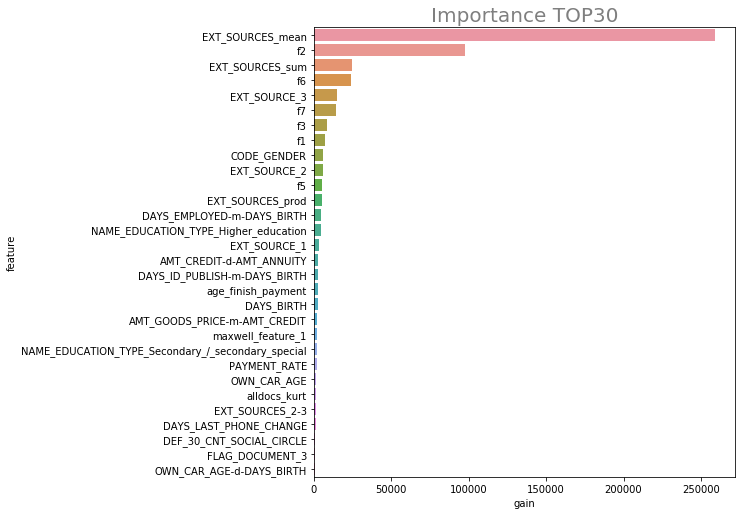

In [104]:
model = lgb.train(param, dtrain, 100)
imp = ex.getImp(model)
ex.pltImp(imp)

In [109]:
train_[['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']].reset_index().to_feather('../feature_someone/train_prev.f')
test_[['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']].reset_index().to_feather('../feature_someone/test_prev.f')

In [110]:
prev.columns.tolist()[-100:]

['NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment',
 'NAME_CASH_LOAN_PURPOSE_Refusal to name the goal',
 'NAME_CASH_LOAN_PURPOSE_Repairs',
 'NAME_CASH_LOAN_PURPOSE_Urgent needs',
 'NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday',
 'NAME_CASH_LOAN_PURPOSE_XAP',
 'NAME_CASH_LOAN_PURPOSE_XNA',
 'NAME_CONTRACT_STATUS_Canceled',
 'NAME_CONTRACT_STATUS_Refused',
 'NAME_CONTRACT_STATUS_Unused offer',
 'NAME_PAYMENT_TYPE_Cashless from the account of the employer',
 'NAME_PAYMENT_TYPE_Non-cash from your account',
 'NAME_PAYMENT_TYPE_XNA',
 'CODE_REJECT_REASON_HC',
 'CODE_REJECT_REASON_LIMIT',
 'CODE_REJECT_REASON_SCO',
 'CODE_REJECT_REASON_SCOFR',
 'CODE_REJECT_REASON_SYSTEM',
 'CODE_REJECT_REASON_VERIF',
 'CODE_REJECT_REASON_XAP',
 'CODE_REJECT_REASON_XNA',
 'NAME_TYPE_SUITE_Family',
 'NAME_TYPE_SUITE_Group of people',
 'NAME_TYPE_SUITE_Other_A',
 'NAME_TYPE_SUITE_Other_B',
 'NAME_TYPE_SUITE_Spouse, partner',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_CLIENT_TYPE_Refreshed',
 'NAME_CLIE